In [1]:
from google.colab import files
uploaded = files.upload()

Saving Corona_NLP_train.csv to Corona_NLP_train.csv


In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

import re 
import nltk 
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

from sklearn.metrics import confusion_matrix


from sklearn.model_selection import GridSearchCV

from sklearn import metrics
import io


import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,SpatialDropout1D

import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy



In [5]:
train= pd.read_csv(io.BytesIO(uploaded['Corona_NLP_train.csv']),encoding = "ISO-8859-1")

In [6]:
x = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()


In [7]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']

           

y.replace(encoding, inplace=True)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    tweet = re.sub('[^a-zA-Z]',' ',tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
#     tweet = tweet.split()
    
    tweet=[word.lower() for word in tweet.split()]
    
    stop_words = stopwords.words('english')
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet
X= x.apply(lambda x : data_cleaner(x))


In [12]:
nltk.download('wordnet')
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [13]:
from nltk.stem import WordNetLemmatizer


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


X = X.apply(lemmatize_text)

In [14]:
X=[" ".join(review) for review in X.values]

In [15]:
voc_size=10000
onehot_repr=[one_hot(words,voc_size)for words in X] 
# onehot_repr

In [16]:
sent_length=25
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 1908 3723 3821]
 [1470 9975 5464 ... 7560 3472 7030]
 [   0    0    0 ... 7758 4343 8171]
 ...
 [   0    0    0 ... 4259  383  589]
 [   0    0    0 ... 3184 4343 3184]
 [3437 3737 6980 ... 4719 4343 5981]]


In [28]:
tf.keras.backend.clear_session()

vocab_size=10000

# hyper parameters

BATCH_SIZE = 32
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=sent_length),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(128, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [20]:
len(embedded_docs),y.shape

(41157, (41157,))

In [21]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [22]:
X_final.shape,y_final.shape

((41157, 25), (41157,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [29]:
history = model.fit(X_train,y_train, epochs=10,validation_data=(X_test,y_test), validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/10
759/759 [==============================] - 8s 10ms/step - loss: 0.7952 - accuracy: 0.6355 - val_loss: 0.6020 - val_accuracy: 0.7597
Epoch 2/10
759/759 [==============================] - 7s 9ms/step - loss: 0.5238 - accuracy: 0.8063 - val_loss: 0.5941 - val_accuracy: 0.7613
Epoch 3/10
759/759 [==============================] - 7s 9ms/step - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.6322 - val_accuracy: 0.7604
Epoch 4/10
759/759 [==============================] - 8s 10ms/step - loss: 0.3675 - accuracy: 0.8685 - val_loss: 0.7025 - val_accuracy: 0.7452
Epoch 5/10
759/759 [==============================] - 8s 10ms/step - loss: 0.3107 - accuracy: 0.8938 - val_loss: 0.8019 - val_accuracy: 0.7392
Epoch 6/10
759/759 [==============================] - 7s 9ms/step - loss: 0.2532 - accuracy: 0.9147 - val_loss: 0.8880 - val_accuracy: 0.7174
Epoch 7/10
759/759 [==============================] - 7s 9ms/step - loss: 0.2000 - accuracy: 0.9358 - val_loss: 1.1059 - val_accuracy: 0.7153
Epo

In [30]:
pred = model.predict_classes(X_test)

In [31]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.553857445716858
Test Accuracy: 0.7023265957832336


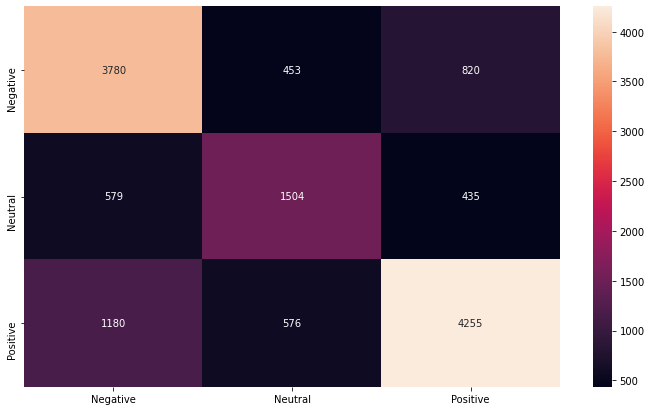

In [32]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()